<h1>Thêm thư viện cần thiết

In [1]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.utils import column_or_1d

warnings.filterwarnings('ignore')


<h1>Nạp dữ liệu

In [2]:
df_train = pd.read_csv("../../../Dataset/bitcoin_train_8_2.csv", parse_dates=True,
                       index_col=0).drop(columns=['Close', 'High', 'Low', 'Volume', 'Currency'])
df_index_train = df_train.index
df_train.head()


,Open
Date,
2020-06-01,9.4545
2020-06-02,10.1907
2020-06-03,9.5270
2020-06-04,9.6672
2020-06-05,9.7940


In [3]:
df_test = pd.read_csv("../../../Dataset/bitcoin_test_8_2.csv", parse_dates=True,
                      index_col=0).drop(columns=['Close', 'High', 'Low', 'Volume', 'Currency'])
df_index_test = df_test.index
df_test.head()


,Open
Date,
2022-01-07,43.0979
2022-01-08,41.5513
2022-01-09,41.6812
2022-01-10,41.8489
2022-01-11,41.8291


# Tạo mới cột Timestamp để dự báo theo chuỗi thời gian

In [4]:
df_train['Timestamp'] = pd.to_datetime(df_train.index).astype(np.int64) / 10**9
df_train.head()


,Open,Timestamp
Date,,
2020-06-01,9.4545,1.590970e+09
2020-06-02,10.1907,1.591056e+09
2020-06-03,9.5270,1.591142e+09
2020-06-04,9.6672,1.591229e+09
2020-06-05,9.7940,1.591315e+09


In [5]:
df_test['Timestamp'] = pd.to_datetime(df_test.index).astype(np.int64) / 10**9
df_test.head()


,Open,Timestamp
Date,,
2022-01-07,43.0979,1.641514e+09
2022-01-08,41.5513,1.641600e+09
2022-01-09,41.6812,1.641686e+09
2022-01-10,41.8489,1.641773e+09
2022-01-11,41.8291,1.641859e+09


# Vẽ đồ thị

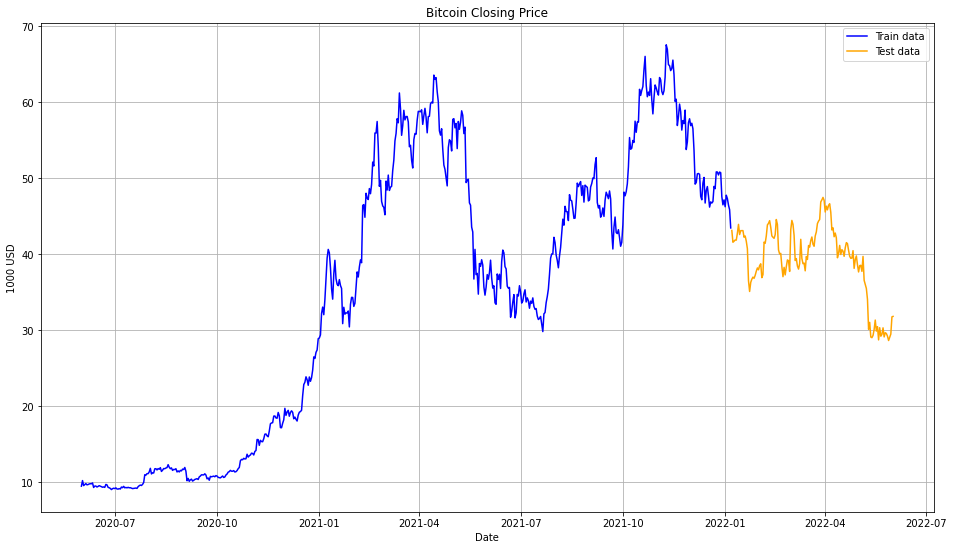

In [6]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.title("Bitcoin Closing Price")
plt.xlabel('Date')
plt.ylabel('1000 USD')
plt.plot(df_train['Open'], 'blue', label='Train data')
plt.plot(df_test['Open'], 'orange', label='Test data')
plt.legend()


# Thực hiện xây dựng mô hình SVR

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [7]:
X_sc_train = StandardScaler()
y_sc_train = StandardScaler()

x_train = df_train.iloc[:, 1].values.reshape(-1, 1)
y_train = df_train.iloc[:, 0].values.reshape(-1, 1)


X_scaled_train = X_sc_train.fit_transform(x_train)
y_scaled_train = y_sc_train.fit_transform(y_train)


df_scaled_train = pd.DataFrame(index=df_index_train)
df_scaled_train['Timestamp'] = X_scaled_train
df_scaled_train['Open'] = y_scaled_train
df_scaled_train.head()


,Timestamp,Open
Date,,
2020-06-01,-1.729093,-1.374369
2020-06-02,-1.723171,-1.334446
2020-06-03,-1.717249,-1.370437
2020-06-04,-1.711328,-1.362834
2020-06-05,-1.705406,-1.355958


In [8]:
X_sc_test = StandardScaler()
y_sc_test = StandardScaler()

x_test = df_test.iloc[:, 1].values.reshape(-1, 1)
y_test = df_test.iloc[:, 0].values.reshape(-1, 1)


X_scaled_test = X_sc_test.fit_transform(x_test)
y_scaled_test = y_sc_test.fit_transform(y_test)


df_scaled_test = pd.DataFrame(index=df_index_test)
df_scaled_test['Timestamp'] = X_scaled_test
df_scaled_test['Open'] = y_scaled_test
df_scaled_test.head()


,Timestamp,Open
Date,,
2022-01-07,-1.720228,0.828744
2022-01-08,-1.696501,0.507663
2022-01-09,-1.672773,0.534630
2022-01-10,-1.649046,0.569446
2022-01-11,-1.625319,0.565335


# Xác định biến độc lập (X) và biến phụ thuộc (y)

In [9]:
X_train = df_scaled_train['Timestamp'].values.reshape(-1, 1)
y_train = df_scaled_train['Open'].values.reshape(-1, 1)

X_test = df_scaled_test['Timestamp'].values.reshape(-1, 1)
y_test = df_scaled_test['Open'].values.reshape(-1, 1)


## Hàm tạo hyperparameters

In [10]:
def para_range(minimum, maximum, step):
    para_list = np.arange(minimum, maximum, step)
    return para_list


# Hàm xuất kết quả của từng trường hợp trong GridSearch

In [11]:
def print_stats(hyperparams, stats):
    if(hyperparams[0] == 'poly'):
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}, degree={hyperparams[3]}')
    else:
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}')

    print(
        f"MAE={stats[0]:.2f} | MAPE={stats[1]:.2f} | MSE={stats[2] :.2f} | RMSE={stats[3]:.2f}")


# Tạo các giá trị cho các hyperparameters

In [12]:
kernels = ['sigmoid', 'rbf', 'poly']
Cs = para_range(0.01, 0.2, 0.1)
gammas = para_range(0.1, 5, 0.1)
degrees = para_range(1, 6, 1)


## GridSearch để tìm hyperparameters phù hợp

In [13]:
warnings.filterwarnings('ignore')

stats_df = pd.DataFrame(
    columns=['kernel', 'C', 'gamma', 'degree', 'MAE', 'MAPE', 'MSE', 'RMSE'])

# Sử dụng gird-seach để tìm hyperparameters phù hợp
for ker in kernels:
    # Nếu kernel == poly thì thực hiện chọn degree
    if(ker != 'poly'):
        for C in Cs:
            for gamma in gammas:
                rgs = SVR(kernel=ker, C=C, gamma=gamma, verbose=False)
                rgs.fit(X_train, y_train)
                pred = rgs.predict(X_test)

                # Đảo tỷ lệ thành giá trị thực
                inv_pred = y_sc_test.inverse_transform(
                    column_or_1d(pred).reshape(-1, 1))
                inv_test = y_sc_test.inverse_transform(
                    column_or_1d(y_test).reshape(-1, 1))
                    
                # Đánh giá mô hình
                mae = mean_absolute_error(inv_test, inv_pred)
                mape = mean_absolute_percentage_error(inv_test, inv_pred)
                mse = mean_squared_error(inv_test, inv_pred)
                rmse = np.sqrt(mse)

                result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': 0,
                          'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                hyperparam = [ker, C, gamma, 0]
                stats = [mae, mape, mse, rmse]
                stats_df = stats_df.append(result, ignore_index=True)
                print_stats(hyperparam, stats)
    else:
        for C in Cs:
            for gamma in gammas:
                for deg in degrees:
                    rgs = SVR(kernel=ker, C=C, gamma=gamma, degree=deg, verbose=False)
                    rgs.fit(X_train, y_train.reshape(-1, 1))
                    pred = rgs.predict(X_test)

                    # Đảo tỷ lệ thành giá trị thực
                    inv_pred = y_sc_test.inverse_transform(
                        column_or_1d(pred).reshape(-1, 1))
                    inv_test = y_sc_test.inverse_transform(
                        column_or_1d(y_test).reshape(-1, 1))

                    # Đánh giá mô hình
                    mae = mean_absolute_error(inv_test, inv_pred)
                    mape = mean_absolute_percentage_error(inv_test, inv_pred)
                    mse = mean_squared_error(inv_test, inv_pred)
                    rmse = np.sqrt(mse)

                    result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': deg,
                            'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                    hyperparam = [ker, C, gamma, deg]
                    stats = [mae, mape, mse, rmse]

                    stats_df = stats_df.append(result, ignore_index=True)

                    print_stats(hyperparam, stats)


SVR(kernel=sigmoid, C=0.01, gamma=0.1
MAE=4.51 | MAPE=0.13 | MSE=35.55 | RMSE=5.96
SVR(kernel=sigmoid, C=0.01, gamma=0.2
MAE=5.54 | MAPE=0.15 | MSE=47.10 | RMSE=6.86
SVR(kernel=sigmoid, C=0.01, gamma=0.30000000000000004
MAE=5.87 | MAPE=0.16 | MSE=51.63 | RMSE=7.19
SVR(kernel=sigmoid, C=0.01, gamma=0.4
MAE=6.00 | MAPE=0.16 | MSE=53.20 | RMSE=7.29
SVR(kernel=sigmoid, C=0.01, gamma=0.5
MAE=6.06 | MAPE=0.17 | MSE=53.82 | RMSE=7.34
SVR(kernel=sigmoid, C=0.01, gamma=0.6
MAE=6.12 | MAPE=0.17 | MSE=54.00 | RMSE=7.35
SVR(kernel=sigmoid, C=0.01, gamma=0.7000000000000001
MAE=6.17 | MAPE=0.17 | MSE=54.03 | RMSE=7.35
SVR(kernel=sigmoid, C=0.01, gamma=0.8
MAE=6.22 | MAPE=0.17 | MSE=53.94 | RMSE=7.34
SVR(kernel=sigmoid, C=0.01, gamma=0.9
MAE=6.22 | MAPE=0.17 | MSE=53.11 | RMSE=7.29
SVR(kernel=sigmoid, C=0.01, gamma=1.0
MAE=6.18 | MAPE=0.17 | MSE=52.20 | RMSE=7.23
SVR(kernel=sigmoid, C=0.01, gamma=1.1
MAE=6.11 | MAPE=0.17 | MSE=51.01 | RMSE=7.14
SVR(kernel=sigmoid, C=0.01, gamma=1.2000000000000002
MAE

In [14]:
best_fit_model = stats_df[stats_df['MAPE']
                          == stats_df['MAPE'].min()].head(1)
best_fit_model


,kernel,C,gamma,degree,MAE,MAPE,MSE,RMSE
652,poly,0.11,4.3,2,3.318767,0.086137,17.941726,4.235767


In [15]:
kernel = str(best_fit_model['kernel'].values[0])
C = float(best_fit_model['C'])
gamma = float(best_fit_model['gamma'])
degree = int(best_fit_model['degree'])

if(kernel == 'poly'):
    rgs = SVR(kernel=kernel, C=C, gamma=gamma, degree=degree)
else:
    rgs = SVR(kernel=kernel, C=C, gamma=gamma)
    
rgs.fit(X_train, y_train.reshape(-1, 1))
pred = rgs.predict(X_test)
pred

array([-1.34610234e+00, -1.30127673e+00, -1.25707369e+00, -1.21349323e+00,
       -1.17053535e+00, -1.12820005e+00, -1.08648733e+00, -1.04539718e+00,
       -1.00492961e+00, -9.65084621e-01, -9.25862209e-01, -8.87262375e-01,
       -8.49285118e-01, -8.11930440e-01, -7.75198340e-01, -7.39088818e-01,
       -7.03601873e-01, -6.68737507e-01, -6.34495718e-01, -6.00876508e-01,
       -5.67879876e-01, -5.35505821e-01, -5.03754345e-01, -4.72625446e-01,
       -4.42119125e-01, -4.12235383e-01, -3.82974218e-01, -3.54335631e-01,
       -3.26319623e-01, -2.98926192e-01, -2.72155339e-01, -2.46007064e-01,
       -2.20481368e-01, -1.95578249e-01, -1.71297708e-01, -1.47639745e-01,
       -1.24604360e-01, -1.02191553e-01, -8.04013242e-02, -5.92336731e-02,
       -3.86886001e-02, -1.87661050e-02,  5.33812084e-04,  1.92111512e-02,
        3.72659124e-02,  5.46980956e-02,  7.15077008e-02,  8.76947280e-02,
        1.03259177e-01,  1.18201049e-01,  1.32520342e-01,  1.46217057e-01,
        1.59291195e-01,  

<h1>Đưa dữ liệu về miền giá trị ban đầu

In [16]:
inv_pred = y_sc_test.inverse_transform(
    column_or_1d(pred).reshape(-1, 1))
inv_test = y_sc_test.inverse_transform(
    column_or_1d(y_test).reshape(-1, 1))


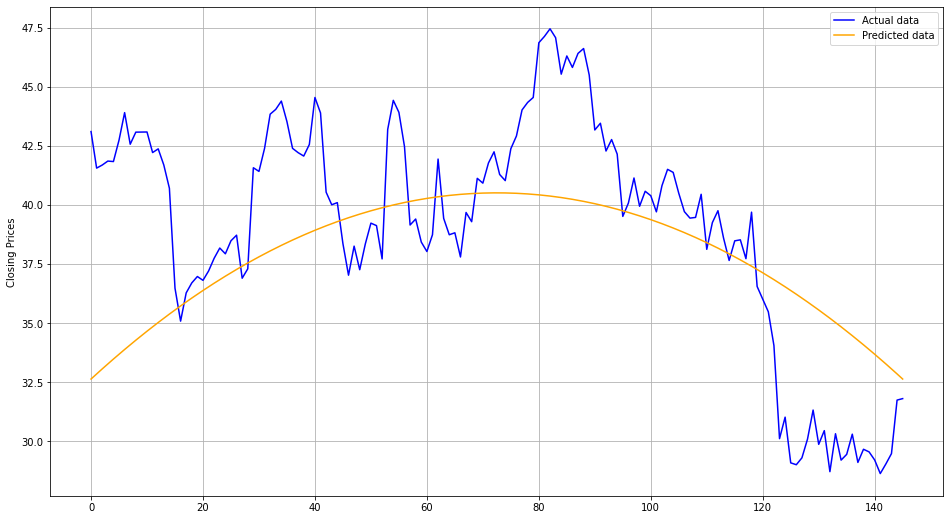

In [17]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
plt.plot(column_or_1d(inv_pred), 'orange', label='Predicted data')
plt.legend()


# Đánh giá mô hình

In [18]:
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"R2: {r2:.2f}")


RMSE: 4.24
MAPE: 8.61%
R2: 0.23
